In this notebook, we explore using Stim to simulate surface code error correction.

In [72]:
import numpy as np
import stim
import matplotlib.pyplot as plt

In [153]:
def init_surface(m, n, error_rate=0.001):
    """
    Initialize an m x n surface code lattice with data and ancilla qubits.
    Returns a Stim Circuit object representing the initialization.
    For simplicity, we assume m and n are both odd.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # Create a Stim Circuit
    circuit = stim.Circuit()

    # Reset all qubits
    circuit.append('R', list(range(2 * m * n - 1)))
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')
    
    # Add qubit coordinates for mn data qubits
    for i in range(m):
        for j in range(n):
            circuit.append("QUBIT_COORDS", i * n + j, [i, j])

    # Add bulk ancilla qubits
    for i in range(m - 1):
        for j in range(n - 1):
            ancilla_index = m * n + i * (n - 1) + j
            circuit.append("QUBIT_COORDS", ancilla_index, [i + 1/2, j + 1/2])

    # Add boundary ancilla qubits
    for i in range(4):
        # X checks on left and right boundaries, totally n - 1 ancilla qubits
        if i % 2 == 0:
            for j in range(n // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (i // 2) * (n // 2) + j
                circuit.append("QUBIT_COORDS", ancilla_index, [-1/2 + i // 2 * m, 2*j + 1/2 + i // 2])
        # Z checks on top and bottom boundaries, totally m - 1 ancilla qubits
        else:
            for j in range(m // 2):
                ancilla_index = m * n + (m - 1) * (n - 1) + (n - 1) + (i // 2) * (m // 2) + j
                circuit.append("QUBIT_COORDS", ancilla_index, [2*j + 1/2 + 1 - i // 2, -1/2 + i // 2 * n])

    return circuit

def syndrome_measurement_surface(circuit: stim.Circuit, m, n, coord: map, error_rate=0.001, if_detector=False, t=0):
    """
    Perform syndrome measurement for the surface code.
    This function adds the necessary gates and measurements to the circuit.
    """
    # Check if m and n are odd
    if m % 2 == 0 or n % 2 == 0:
        raise ValueError("Both m and n must be odd integers.")

    # initialize X-check ancillae
    for idx in range(m * n, 2 * m * n - 1):
        if int(np.sum(coord[idx])) % 2 == 0:
            circuit.append('H', idx)
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # first CNOT layer, for bulk and bottom/right boundary ancillae
    for idx in range(m * n, 2 * m * n - 1):
        pos = coord[idx]
        if int(np.sum(pos)) % 2 == 0 and pos[0] > 0:  # X-check ancilla
            data_idx = int((pos[0] - 1/2) * n + (pos[1] - 1/2))
            circuit.append('CNOT', [idx, data_idx])
        elif int(np.sum(pos)) % 2 == 1 and pos[1] > 0:  # Z-check ancilla
            data_idx = int((pos[0] - 1/2) * n + (pos[1] - 1/2))
            circuit.append('CNOT', [data_idx, idx])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # second CNOT layer, for bulk and bottom/right boundary ancillae
    for idx in range(m * n, 2 * m * n - 1):
        pos = coord[idx]
        if int(np.sum(pos)) % 2 == 0 and pos[0] > 0:  # X-check ancilla
            data_idx = int((pos[0] - 1/2) * n + (pos[1] + 1/2))
            circuit.append('CNOT', [idx, data_idx])
        elif int(np.sum(pos)) % 2 == 1 and pos[1] > 0:  # Z-check ancilla
            data_idx = int((pos[0] + 1/2) * n + (pos[1] - 1/2))
            circuit.append('CNOT', [data_idx, idx])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # third CNOT layer, for bulk and top/left boundary ancillae
    for idx in range(m * n, 2 * m * n - 1):
        pos = coord[idx]
        if int(np.sum(pos)) % 2 == 0 and pos[0] < m - 1:  # X-check ancilla
            data_idx = int((pos[0] + 1/2) * n + (pos[1] - 1/2))
            circuit.append('CNOT', [idx, data_idx])
        elif int(np.sum(pos)) % 2 == 1 and pos[1] < n - 1:  # Z-check ancilla
            data_idx = int((pos[0] - 1/2) * n + (pos[1] + 1/2))
            circuit.append('CNOT', [data_idx, idx])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # fourth CNOT layer, for bulk and top/left boundary ancillae
    for idx in range(m * n, 2 * m * n - 1):
        pos = coord[idx]
        if int(np.sum(pos)) % 2 == 0 and pos[0] < m - 1:  # X-check ancilla
            data_idx = int((pos[0] + 1/2) * n + (pos[1] + 1/2))
            circuit.append('CNOT', [idx, data_idx])
        elif int(np.sum(pos)) % 2 == 1 and pos[1] < n - 1:  # Z-check ancilla
            data_idx = int((pos[0] + 1/2) * n + (pos[1] + 1/2))
            circuit.append('CNOT', [data_idx, idx])
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # Hadamard layer for X-check ancillae
    for idx in range(m * n, 2 * m * n - 1):
        if int(np.sum(coord[idx])) % 2 == 0:
            circuit.append('H', idx)
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # final measurements
    circuit.append('MR', list(range(m * n, 2 * m * n - 1)))
    circuit.append("DEPOLARIZE1", list(range(2 * m * n - 1)), error_rate)
    circuit.append('TICK')

    # if detector is required, add detector operations
    if if_detector:
        for idx in range(- m * n + 1, 0):
            pos = coord[idx + 2 * m * n - 1]
            circuit.append('DETECTOR', [stim.target_rec(idx), stim.target_rec(idx - m * n + 1)], [pos[0], pos[1], t])

def full_surface(m, n, error_rate=0.001, num_rounds=1):
    """
    Create a full surface code circuit with syndrome measurement.
    m and n are the dimensions of the surface code lattice.
    """
    circuit = init_surface(m, n)
    coord = circuit.get_final_qubit_coordinates()
    
    # Perform syndrome measurement
    for t in range(num_rounds):
        if_detector = (t > 0)
        syndrome_measurement_surface(circuit, m, n, coord, error_rate, if_detector, t)

    return circuit

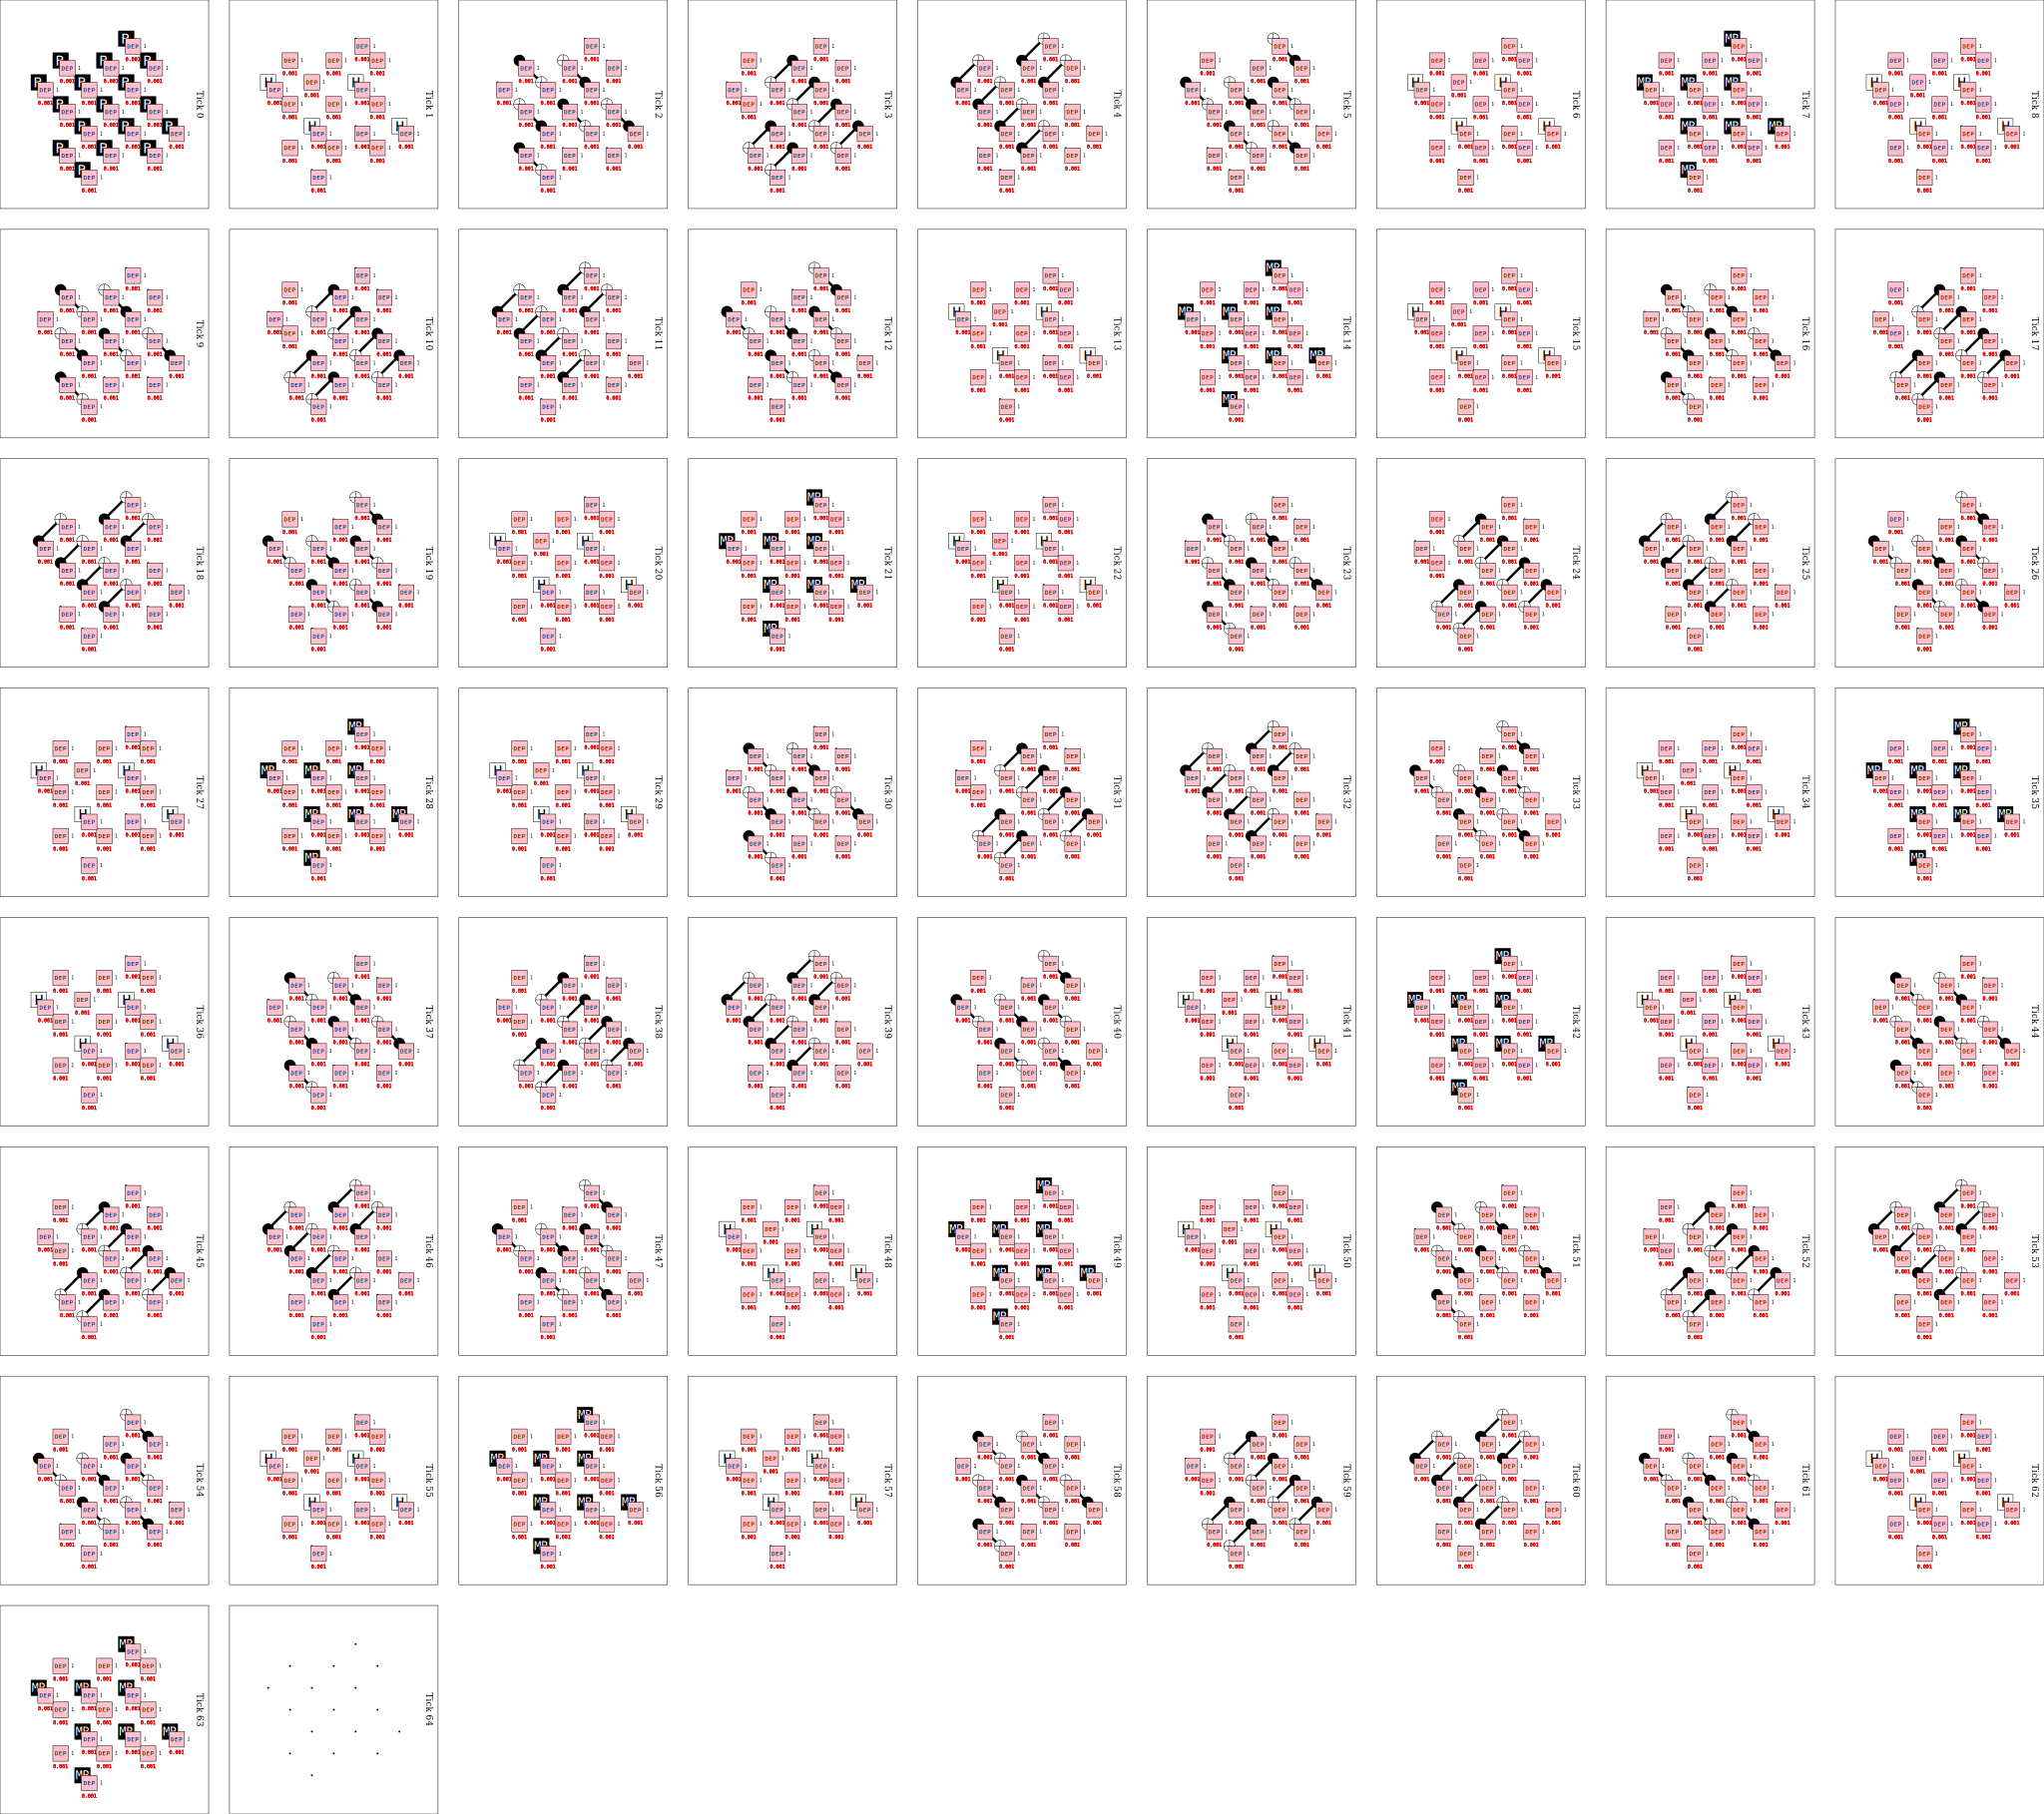

In [157]:
m, n = 3, 3
circuit = full_surface(m, n, 0.001, 9)
circuit.diagram('timeslice-svg')

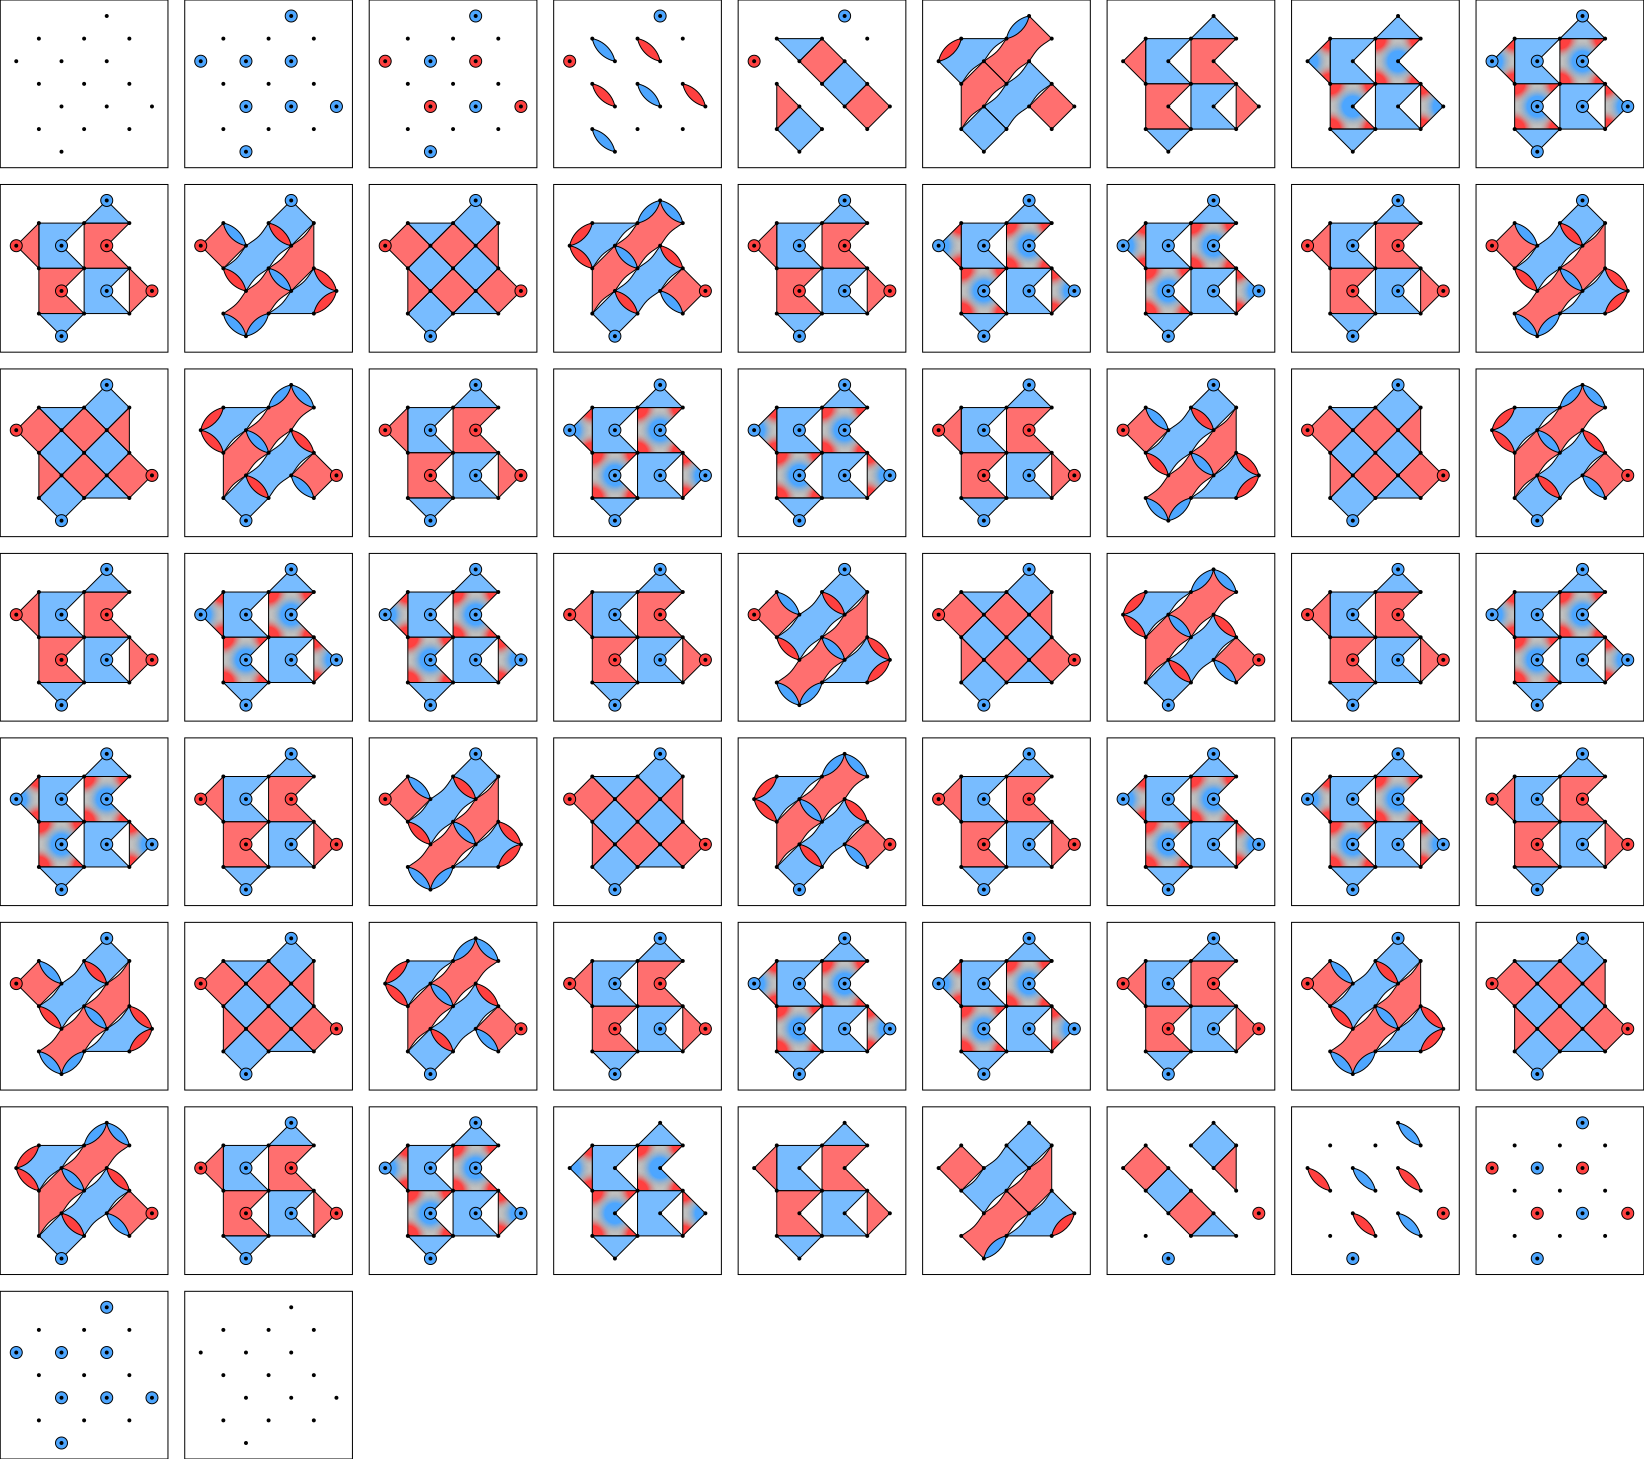

In [158]:
circuit.diagram('detslice-svg')

In [159]:
circuit.diagram('matchgraph-3d')

{"accessors":[{"bufferView":0,"byteOffset":0,"componentType":5126,"count":9,"max":[0,0.400000005960464,0.400000005960464],"min":[0,-0.400000005960464,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":1,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0,0.400000005960464],"min":[-0.400000005960464,0,-0.400000005960464],"name":"circle_loop","type":"VEC3"},{"bufferView":2,"byteOffset":0,"componentType":5126,"count":9,"max":[0.400000005960464,0.400000005960464,0],"min":[-0.400000005960464,-0.400000005960464,0],"name":"circle_loop","type":"VEC3"},{"bufferView":3,"byteOffset":0,"componentType":5126,"count":1672,"max":[16.5453414916992,16.5453414916992,33.8019599914551],"min":[-10.5453414916992,-10.5453414916992,-6.80196094512939],"name":"buf_scattered_lines","type":"VEC3"}],"asset":{"version":"2.0"},"bufferViews":[{"buffer":0,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":1,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":2,"byteLength":108,"byteOffset":0,"name":"circle_loop","target":34962},{"buffer":3,"byteLength":20064,"byteOffset":0,"name":"buf_scattered_lines","target":34962}],"buffers":[{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAM3MzD4AAAAAAAAAAMPQkD7D0JA+AAAAAPIwlrLNzMw+AAAAAMPQkL7D0JA+AAAAAM3MzL7yMBazAAAAAMHQkL7E0JC+AAAAAPLkozHNzMy+AAAAAMbQkD6/0JC+AAAAAM3MzD4AAAAA"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,AAAAAAAAAADNzMw+w9CQPgAAAADD0JA+zczMPgAAAADyMJayw9CQPgAAAADD0JC+8jAWswAAAADNzMy+xNCQvgAAAADB0JC+zczMvgAAAADy5KMxv9CQvgAAAADG0JA+AAAAAAAAAADNzMw+"},{"byteLength":108,"name":"circle_loop","uri":"data:application/octet-stream;base64,zczMPgAAAAAAAAAAw9CQPsPQkD4AAAAA8jCWss3MzD4AAAAAw9CQvsPQkD4AAAAAzczMvvIwFrMAAAAAwdCQvsTQkL4AAAAA8uSjMc3MzL4AAAAAxtCQPr/QkL4AAAAAzczMPgAAAAAAAAAA"},{"byteLength":20064,"name":"buf_scattered_lines","uri":"data:application/octet-stream;base64,AADAPwAAwD8AAEBAADrMPQA6zD2qqdnAAADAPwAAwD8AAEBAAACQQAAAkEAAAEBAAADAPwAAwD8AAEBAAACQQAAAkEAAAEBAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAADAPwAAwD8AAEBAAACQQAAAwL8AAEBAAADAPwAAwD8AAEBAAACQQAAAwL8AAEBAAACQQAAAwD8AAEBAGM+8QAA6zD2qqdnAAADAPwAAwD8AAEBAAACQQAAAwL8AAEBAAACQQAAAwD8AAEBAAACQQAAAwD8AAMBAAADAPwAAwD8AAEBAAACQQAAAwL8AAEBAAACQQAAAwD8AAMBAg5XNQDBY2b4g12fAAADAPwAAwD8AAEBAAADAPwAAwD8AAMBAAADAPwAAwD8AAEBAAADAPwAAwD8AAMBAAADAvwAAwD8AAEBAOvuswJDdSj6In8PAAADAPwAAwD8AAEBAAADAPwAAwD8AAMBAAADAvwAAwD8AAEBAAACQQAAAwD8AAMBAAADAPwAAwD8AAEBAAADAPwAAwD8AAMBAAADAPwAAkEAAAMBAAACQQAAAwD8AAMBAAADAPwAAwD8AAEBAAACQQAAAkEAAAMBAAADAPwAAwD8AAEBAAACQQAAAkEAAAMBAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAADAPwAAwD8AAEBAAACQQAAAkEAAAMBAAADAPwAAkEAAAEBAAACQQAAAwD8AAMBAAADAPwAAwD8AAEBAAACQQAAAkEAAAMBAAADAPwAAkEAAAMBAAACQQAAAwD8AAMBAAADAPwAAwD8AAEBAAADAPwAA8EAAAMBAAADAPwAAwD8AAEBAAADAPwAA8EAAAMBAAADAPwAAkEAAAEBAAADAPwAAkEAAAMBAAADAPwAAkEAAAEBAADrMPRjPvECqqdnAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAADAPwAAwD8AAEBAADrMPQA6zD2qqdnAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAACQQAAAkEAAAEBAGM+8QBjPvECqqdnAAADAPwAAkEAAAEBAAACQQAAAwD8AAEBAAACQQAAAkEAAAEBAAACQQAAAkEAAAMBAAADAPwAAkEAAAEBAAADAvwAAwD8AAEBAAADAPwAAkEAAAEBAAADAvwAAwD8AAEBAAADAPwAAwD8AAEBAADrMPQA6zD2qqdnAAADAPwAAkEAAAEBAAADAPwAAkEAAAMBAAADAPwAAkEAAAEBAAADAPwAAkEAAAMBAAADAPwAAwD8AAEBAADrMPQA6zD2qqdnAAADAPwAAkEAAAEBAAADAPwAAkEAAAMBAAACQQAAAkEAAAMBAAADAPwAA8EAAAMBAAADAPwAAkEAAAEBAAACQQAAAwD8AAMBAAADAPwAAkEAAAEBAAADwQAAAkEAAAMBAAADAPwAAkEAAAEBAAADwQAAAkEAAAMBAAACQQAAAkEAAAEBAAACQQAAAkEAAAMBAAADAPwAAkEAAAEBAADrMPRjPvECqqdnAAADAPwAAwD8AAEBAADrMPQA6zD2qqdnAAADAPwAAkEAAAEBAADrMPRjPvECqqdnAAADAPwAA8EAAAEBAkN1KPp19NkGIn8PAAADAPwAAkEAAAEBAADrMPRjPvECqqdnAAADAPwAA8EAAAMBAOOBCvoIiSUEQ5hzAAACQQAAAwD8AAEBAGM+8QAA6zD2qqdnAAACQQAAAwD8AAEBAAADwQAAAkEAAAEBAAACQQAAAwD8AAEBAAADwQAAAkEAAAEBAAACQQAAAkEAAAEBAGM+8QBjPvECqqdnAAACQQAAAwD8AAEBAAACQQAAAwD8AAMBAAACQQAAAwD8AAEBAAACQQAAAwD8AAMBAAACQQAAAwL8AAEBAAACQQAAAkEAAAMBAAACQQAAAwD8AAEBAAACQQAAAwD8AAMBAAACQQAAAkEAAAMBAg5XNQIOVz